In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0

In [65]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

In [66]:
# Load in the query from file
query='SELECT * FROM OASIS'
oasis = pd.read_sql_query(query, connect)

In [67]:
oasis.head()

,subject_id,hadm_id,icustay_id,icustay_age_group,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
0,55973,152234,200001,adult,0,0,42,0.305849,61.0,6,7 days 03:02:12,1,14.0,3.0,134.0,6.0,60.000000,2.0,32.0,6.0,36.388889,2.0,250.0,10.0,0,0,0,6
1,27513,163557,200003,adult,0,0,35,0.152892,48.0,3,0 days 02:48:04,3,15.0,0.0,122.0,3.0,179.000000,3.0,39.0,6.0,36.388889,2.0,3652.0,0.0,1,9,0,6
2,10950,189514,200006,adult,0,0,32,0.109623,54.0,6,0 days 00:01:14,5,15.0,0.0,73.0,0.0,61.000000,2.0,27.0,1.0,36.166666,2.0,1955.0,1.0,1,9,0,6
3,20707,129310,200007,adult,0,0,26,0.054187,43.0,3,0 days 00:01:37,5,15.0,0.0,104.0,1.0,50.666698,3.0,29.0,1.0,36.388889,2.0,1295.0,5.0,0,0,0,6
4,29904,129607,200009,adult,0,0,25,0.048012,47.0,3,-1 days +23:49:32,5,15.0,0.0,106.0,1.0,60.000000,2.0,17.5,0.0,34.599998,4.0,1570.0,1.0,1,9,1,0


In [68]:
oasis.shape

(61532, 28)

In [69]:
oasis.loc[oasis.urineoutput > 10000,'urineoutput'] = 10000
oasis.loc[oasis.urineoutput < 0,'urineoutput'] = np.nan
oasis.loc[oasis.temp < 32,'temp'] = np.nan
oasis.loc[oasis.temp > 42,'temp'] = 42
oasis['preiculos_hours'] = oasis.preiculos.dt.total_seconds()/3600
oasis.loc[oasis.preiculos_hours > 24*14,'preiculos_hours'] = 24*14
oasis.loc[oasis.age > 299,'age'] = 89
oasis = oasis.loc[(oasis.icustay_age_group == 'adult')]

In [70]:
oasis.shape

(53431, 29)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24e1dac8>,
      dtype=object)

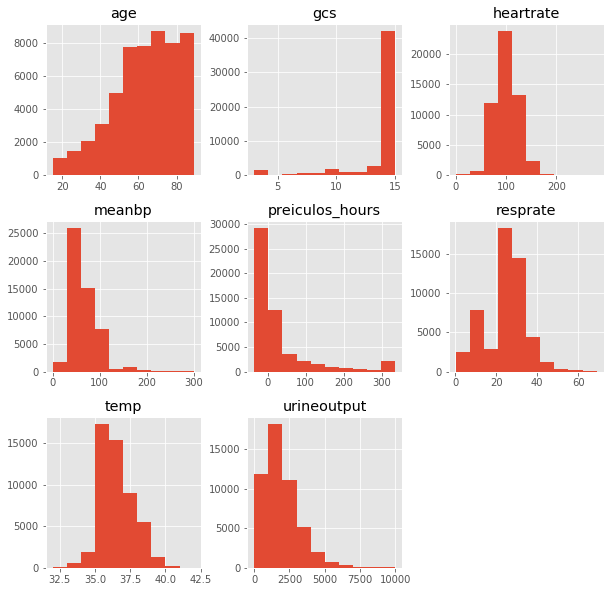

In [71]:
feats = ['age', 'preiculos_hours', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp', 'urineoutput']
oasis[feats].hist(figsize=(10,10))

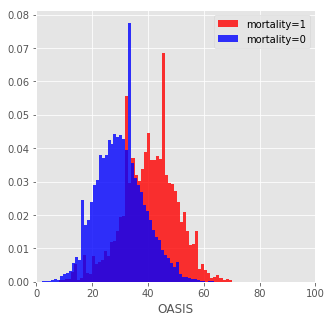

In [72]:
f, axs = plt.subplots(1,1,figsize=(5,5))

plt.hist(oasis.loc[oasis.icustay_expire_flag == 1].oasis,density=1,color='red',label='mortality=1',bins=57,alpha=0.8)
plt.hist(oasis.loc[oasis.icustay_expire_flag == 0].oasis,density=1,color='blue',label='mortality=0',bins=63,alpha=0.8)
plt.legend(loc='best')
plt.xlim(0,100)
plt.xlabel('OASIS')

plt.savefig('oasis.pdf')

In [73]:
num_features = ['age', 'preiculos_hours', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp', 'urineoutput']
cat_features = ['mechvent', 'electivesurgery']
X = oasis[num_features + cat_features + ['oasis_prob']]
y = oasis.hospital_expire_flag

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.25, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)
oasis_prob_test = X_test_orig['oasis_prob']
X_train_orig = X_train_orig.drop(['oasis_prob'],axis=1)
X_test_orig = X_test_orig.drop(['oasis_prob'],axis=1)

In [74]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (40073, 10)
Shape of test set: (13358, 10)
Number of positives in training set: 4909
Number of positives in test set: 1636


In [75]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

cat_impute = ('cat_impute', SimpleImputer(strategy='constant', fill_value=2))
onehot = ('onehot', OneHotEncoder(handle_unknown='error',categories='auto'))
cat_transformer = Pipeline(steps=[cat_impute,onehot])

preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

In [61]:
OneHotEncoder?

In [79]:
lr = LogisticRegression(random_state=rnd_state,solver='lbfgs',max_iter=1000,class_weight='balanced',C=1.,tol=0.0001)

lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
F1 = f1_score(y_test, predictions)
auroc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
res = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.377 auroc: 0.790 precision: 0.254 recall: 0.727


In [80]:
auroc = roc_auc_score(y_test, oasis_prob_test)
res = 'OASIS auroc: {0:.3f}'.format(auroc)
print(res)

OASIS auroc: 0.768


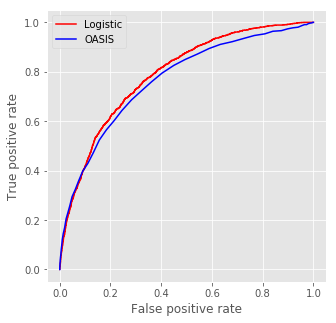

In [81]:
f, axs = plt.subplots(1,1,figsize=(5,5))

a,b,c = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(a,b,label='Logistic',color='red')
a,b,c = roc_curve(y_test, oasis_prob_test)
plt.plot(a,b,label='OASIS',color='blue')
plt.legend(loc='best')
axs.set_xlabel('False positive rate')
axs.set_ylabel('True positive rate')

plt.savefig('logistic_oasis.pdf')

In [82]:
gbc = GradientBoostingClassifier(random_state=rnd_state)
gbc.fit(X_train, y_train,sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
predictions = gbc.predict(X_test)
F1 = f1_score(y_test, predictions)
auroc = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
res = 'TEST SET f1: {0:.3f} auroc: {1:.3f} precision: {2:.3f} recall: {3:.3f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.436 auroc: 0.838 precision: 0.306 recall: 0.757


Text(0, 0.5, 'Feature Importance Score')

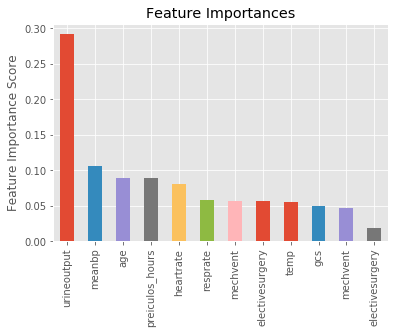

In [90]:
features = num_features + [b for a in list(zip(cat_features, cat_features)) for b in a]
feat_imp = pd.Series(gbc.feature_importances_, features).sort_values(ascending=False)
feat_imp.iloc[0:30].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')